In [1]:
import pandas as pd
from requests import get
from bs4 import BeautifulSoup
import os
import path
import re

import unicodedata
import re
import json

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.metrics import classification_report, accuracy_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# read the html file from a file in the curent working directory ('GitHubTopStars_repos.html')
def read_GitHub_most_stars(filename):
    with open(filename) as f:
        contents = f.read()
    return contents


def parse_urls(contents):
    soup = BeautifulSoup(contents, 'html.parser')
    title = soup.title
    orig_text = soup.text
    stars = soup.find_all('a', class_= 'v-align-middle')
    #  find all the "hrefs", which are the trending titles
    return(re.findall(r'href="(.*?)"', str(stars)))


# Grabs the language and body for each git repo as a dictionary and adds to a list
def get_git_info(star_list):
#   Github base url
    github_base_url = 'https://github.com'
    git_repo_url = []
    
#   Adds the repo portion of address
    for repo in star_list:
        git_repo_url.append(github_base_url + repo)

    list_of_git_info = []

    for repo_address in git_repo_url:
#       Grabbs the language from the repo website  
        git_repo_url = repo_address 
        headers = {'User-Agent': 'Codeup Ada Data Science'}
        response = get(git_repo_url, headers=headers)
        soup = BeautifulSoup(response.content, 'html.parser')
        language = soup.find('span', class_='lang')

#       This adds the part to get to the readme and scrapes the body  
        readme_end = '/blob/master/README.md'
        readme_url = git_repo_url + readme_end
        headers = {'User-Agent': 'Codeup Ada Data Science'}
        response = get(readme_url, headers=headers)
        soup = BeautifulSoup(response.content, 'html.parser')
        body = soup.find('article', class_="markdown-body entry-content p-3 p-md-6")

#       Combines the language and body to a dictionary, if no language on the repo it is ignored
        if language != None:
            language = str(language)
            list_of_git_info.append({'Language': re.findall(r'>(.*?)<', language)[0],
                                     'Body': body})

    return list_of_git_info


# If the readme is empty it is dropped
def drop_empty_readmes(repos):
    output = []
    for repo in repos:
        if repo['Body'] != None:
            output.append(repo)
    return output


# Finds the number of unique words 
def find_nunique(string):
    words = string.split(" ")
    unique_words = set(words)
    return len(unique_words)


# Grabbs only words
def regex_it(string):
    return ' '.join(re.findall(r'[a-z]+', string))


def basic_clean(repo):
    repo = re.sub(r'\s', ' ', repo).lower()
    repo = unicodedata.normalize('NFKD', repo)\
        .encode('ascii', 'ignore')\
        .decode('utf-8', 'ignore')
    repo = re.sub(r"[^a-z0-9'\s]", '', repo)
    return repo


def tokenize(repo):
    tokenizer = nltk.tokenize.ToktokTokenizer()
    repo = tokenizer.tokenize(repo, return_str=True)
    return repo
    

def stem(repo):
    ps = nltk.porter.PorterStemmer()
    stems = [ps.stem(word) for word in repo.split()]
    repo_stemmed = ' '.join(stems)
    return repo_stemmed


def lemmatize(repo):
    wnl = nltk.stem.WordNetLemmatizer()
    lemmas = [wnl.lemmatize(word) for word in repo.split()]
    repo_lemmatized = ' '.join(lemmas)
    return repo_lemmatized


def remove_stopwords(repo, extra_words = [], exclude_words = []):
    stopword_list = stopwords.words('english')
    [stopword_list.append(word) for word in extra_words if word not in stopword_list]
    [stopword_list.remove(word) for word in exclude_words if word in stopword_list]
    words = repo.lower().split()
    filtered_words = [w for w in words if w not in stopword_list]
    repo_without_stopwords = ' '.join(filtered_words)
    return repo_without_stopwords


def prep_repo(dictionary_repo, extra_words = [], exclude_words = []):
    cleaned_dict = {
    'language': dictionary_repo['Language'],
    'original': dictionary_repo['Body'],
    'stemmed': stem(dictionary_repo['Body']),
    'lemmatized': lemmatize(dictionary_repo['Body']),
    'clean': remove_stopwords(basic_clean(dictionary_repo['Body']), extra_words, exclude_words),
        }

    return cleaned_dict


def prepare_repo_data(dictionary_repo, extra_words = [], exclude_words = []):
    clean_dict_list = []
    
    for repo in dictionary_repo:
        clean_dict_list.append(prep_repo(repo, extra_words, exclude_words))
        
    return clean_dict_list


def get_df(bulk):
    return pd.DataFrame(prepare_repo_data(bulk))

In [3]:
# Can read csv to save time!

df = pd.read_csv('git_repo_nlp.csv')
df2 = pd.read_csv('github_data.csv', index_col=0)


In [4]:
# df2 is repos from orion that we shape up to use

df2.rename(columns={'readme': 'original'}, inplace=True)
df2['clean'] = df2.original.apply(remove_stopwords, basic_clean)


In [5]:
# adding orions
df = df.append(df2)

# dropping any duplicates
df = df.drop_duplicates()

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [6]:
# #  turn off the web access for now and just read the cached files from the working directory
# #  contents = get_GitHub_most_stars()
# list_of_html_files = ['GitHubTopStars_repos-page1.html','GitHubTopStars_repos-page2.html',\
#                       'GitHubTopStars_repos-page3.html','GitHubTopStars_repos-page4.html',\
#                       'GitHubTopStars_repos-page5.html','GitHubTopStars_repos-page6.html',\
#                       'GitHubTopStars_repos-page7.html','GitHubTopStars_repos-page8.html',\
#                       'GitHubTopStars_repos-page9.html','GitHubTopStars_repos-page10.html',\
#                       'GitHubTopStars_repos-page11.html','GitHubTopStars_repos-page12.html',\
#                       'GitHubTopStars_repos-page13.html']

# star_list = []
# for html_file in list_of_html_files:
#     contents = read_GitHub_most_stars(html_file)
#     next_list = parse_urls(contents)
#     star_list = star_list + next_list

In [7]:
# github_base_url = 'https://github.com'

# git_repo_url = []

# for repo in star_list:
#     git_repo_url.append(github_base_url + repo)
        

In [8]:
# bulk = get_git_info(star_list)

In [9]:
# bulk = drop_empty_readmes(bulk)


In [10]:
# for repo in bulk:
#     repo['Body'] = repo['Body'].text.strip()
    

In [11]:
# df = get_df(bulk)

In [12]:
# Checking language representaion

df.language.value_counts()

JavaScript          105
Python               33
Java                 20
Go                   18
C++                  17
TypeScript           10
CSS                   9
HTML                  6
C                     6
Shell                 5
Vue                   5
Ruby                  5
Kotlin                3
Rust                  3
Swift                 2
Dart                  2
Objective-C           2
C#                    1
Clojure               1
PHP                   1
Vim script            1
Dockerfile            1
TeX                   1
Assembly              1
Jupyter Notebook      1
Name: language, dtype: int64

In [13]:
# removing the low pop ones, under 10

df = df[df.language != 'C']
df = df[df.language != 'HTML']
df = df[df.language != 'Shell']
df = df[df.language != 'Vue']
df = df[df.language != 'Ruby']
df = df[df.language != 'Kotlin']
df = df[df.language != 'Rust']
df = df[df.language != 'Dart']
df = df[df.language != 'Objective-C']
df = df[df.language != 'Swift']
df = df[df.language != 'Clojure']
df = df[df.language != 'Jupyter Notebook']
df = df[df.language != 'TeX']
df = df[df.language != 'C#']
df = df[df.language != 'Vim script']
df = df[df.language != 'Assembly']
df = df[df.language != 'Dockerfile']
df = df[df.language != 'PHP']



In [14]:
# Getting only words and stemming them

df.clean = df.clean.apply(regex_it)
df.clean = df.clean.apply(stem)

In [15]:
# getting the words for each language

all_words = ' '.join(df['clean'])
js_words = ' '.join(df['clean'][df.language == 'JavaScript'])
python_words = ' '.join(df['clean'][df.language == 'Python'])
cpp_words = ' '.join(df['clean'][df.language == 'C++'])
typeScript_words = ' '.join(df['clean'][df.language == 'TypeScript'])
go_words = ' '.join(df['clean'][df.language == 'Go'])
java_words = ' '.join(df['clean'][df.language == 'Java'])
css_words = ' '.join(df['clean'][df.language == 'CSS'])



In [16]:
# finding the frequency for each word for each language

all_freq = pd.Series(all_words.split()).value_counts()
js_freq = pd.Series(js_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
cpp_freq = pd.Series(cpp_words.split()).value_counts()
typeScript_freq = pd.Series(typeScript_words.split()).value_counts()
go_freq = pd.Series(go_words.split()).value_counts()
java_freq = pd.Series(java_words.split()).value_counts()
css_freq = pd.Series(css_words.split()).value_counts()



In [17]:
df.language.value_counts()

JavaScript    105
Python         33
Java           20
Go             18
C++            17
TypeScript     10
CSS             9
Name: language, dtype: int64

In [18]:
# Bag of words

word_counts = (pd.concat([all_freq, js_freq, python_freq, cpp_freq,typeScript_freq,
                          go_freq, java_freq, css_freq, ], axis=1, sort=True)
                          .set_axis(['all', 'js', 'python', 'cpp', 'ts', 'go', 'java','scc'], axis=1, inplace=False)
                          .fillna(0)
                          .apply(lambda s: s.astype(int)))



What are the most common words in READMEs?


In [19]:
# top 20 most popular words 

word_counts.sort_values(by='all', ascending=False).head(20)


,all,js,python,cpp,ts,go,java,scc
use,4504,2979,779,120,16,443,127,40
go,2313,166,76,3,1,2061,5,1
react,2029,1992,7,0,7,0,1,22
code,1951,1317,316,58,26,183,35,16
nativ,1892,1801,36,5,2,45,3,0
function,1811,1539,128,7,0,108,21,8
const,1652,1641,0,6,0,0,0,5
data,1644,580,830,13,0,174,43,4
librari,1620,259,631,28,0,664,35,3
exampl,1616,1207,279,18,5,66,34,7


Does the length of the README vary by language?


In [20]:
df['readme_length'] = df.clean.str.len()
df[['language','readme_length']].groupby('language').mean().sort_values('readme_length', ascending=False)


,readme_length
language,
Python,15687.727273
Go,15240.555556
JavaScript,10915.295238
Java,3302.000000
C++,2929.411765
CSS,1826.777778
TypeScript,1005.500000


Do different languages use a different number of unique words?

In [21]:
df['unique_words'] = df.clean.apply(find_nunique)
df[['language','unique_words']].groupby('language').mean().sort_values('unique_words', ascending=False)


,unique_words
language,
Go,658.055556
Python,639.272727
JavaScript,440.028571
C++,214.941176
Java,202.050000
CSS,154.222222
TypeScript,95.900000


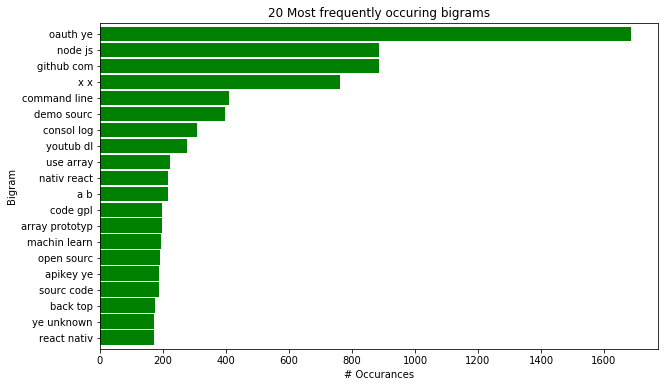

In [22]:
top_bigrams = (pd.Series(nltk.ngrams(all_words.split(), 2))
                      .value_counts()
                      .head(20))

top_bigrams.sort_values().plot.barh(color='green', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [23]:
cv = CountVectorizer()
X = cv.fit_transform(df.clean)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=123)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))



In [24]:
lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Train:')
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---'*21)
print(classification_report(train.actual, train.predicted))

print('---'*25)

print('Test:')
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---'*21)
print(classification_report(test.actual, test.predicted))

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Train:
Accuracy: 100.00%
------------------
Confusion Matrix
actual      C++  CSS  Go  Java  JavaScript  Python  TypeScript
predicted                                                     
C++          14    0   0     0           0       0           0
CSS           0    7   0     0           0       0           0
Go            0    0  14     0           0       0           0
Java          0    0   0    16           0       0           0
JavaScript    0    0   0     0          84       0           0
Python        0    0   0     0           0      26           0
TypeScript    0    0   0     0           0       0           8
---------------------------------------------------------------
              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        14
         CSS       1.00      1.00      1.00         7
          Go       1.00      1.00      1.00        14
        Java       1.00      1.00      1.00        16
  JavaScript       1.00      1.00    

In [25]:
lm = LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Train:')
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---'*21)
print(classification_report(train.actual, train.predicted))

print('---'*25)

print('Test:')
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---'*21)
print(classification_report(test.actual, test.predicted))

Train:
Accuracy: 100.00%
------------------
Confusion Matrix
actual      C++  CSS  Go  Java  JavaScript  Python  TypeScript
predicted                                                     
C++          14    0   0     0           0       0           0
CSS           0    7   0     0           0       0           0
Go            0    0  14     0           0       0           0
Java          0    0   0    16           0       0           0
JavaScript    0    0   0     0          84       0           0
Python        0    0   0     0           0      26           0
TypeScript    0    0   0     0           0       0           8
---------------------------------------------------------------
              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        14
         CSS       1.00      1.00      1.00         7
          Go       1.00      1.00      1.00        14
        Java       1.00      1.00      1.00        16
  JavaScript       1.00      1.00    

In [26]:
lm = DecisionTreeClassifier(max_depth=20).fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Train:')
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---'*21)
print(classification_report(train.actual, train.predicted))

print('---'*25)

print('Test:')
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---'*21)
print(classification_report(test.actual, test.predicted))

Train:
Accuracy: 100.00%
------------------
Confusion Matrix
actual      C++  CSS  Go  Java  JavaScript  Python  TypeScript
predicted                                                     
C++          14    0   0     0           0       0           0
CSS           0    7   0     0           0       0           0
Go            0    0  14     0           0       0           0
Java          0    0   0    16           0       0           0
JavaScript    0    0   0     0          84       0           0
Python        0    0   0     0           0      26           0
TypeScript    0    0   0     0           0       0           8
---------------------------------------------------------------
              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        14
         CSS       1.00      1.00      1.00         7
          Go       1.00      1.00      1.00        14
        Java       1.00      1.00      1.00        16
  JavaScript       1.00      1.00    

In [27]:
lm = RandomForestClassifier().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Train:')
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---'*21)
print(classification_report(train.actual, train.predicted))

print('---'*25)

print('Test:')
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---'*21)
print(classification_report(test.actual, test.predicted))

Train:
Accuracy: 100.00%
------------------
Confusion Matrix
actual      C++  CSS  Go  Java  JavaScript  Python  TypeScript
predicted                                                     
C++          14    0   0     0           0       0           0
CSS           0    7   0     0           0       0           0
Go            0    0  14     0           0       0           0
Java          0    0   0    16           0       0           0
JavaScript    0    0   0     0          84       0           0
Python        0    0   0     0           0      26           0
TypeScript    0    0   0     0           0       0           8
---------------------------------------------------------------
              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        14
         CSS       1.00      1.00      1.00         7
          Go       1.00      1.00      1.00        14
        Java       1.00      1.00      1.00        16
  JavaScript       1.00      1.00    

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_

In [28]:
lm = KNeighborsClassifier(n_neighbors=2).fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Train:')
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---'*21)
print(classification_report(train.actual, train.predicted))

print('---'*25)

print('Test:')
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---'*21)
print(classification_report(test.actual, test.predicted))

Train:
Accuracy: 86.98%
------------------
Confusion Matrix
actual      C++  CSS  Go  Java  JavaScript  Python  TypeScript
predicted                                                     
C++          14    0   2     0           1       3           1
CSS           0    7   0     0           2       0           0
Go            0    0  12     1           1       3           0
Java          0    0   0    15           3       1           0
JavaScript    0    0   0     0          77       3           1
Python        0    0   0     0           0      16           0
TypeScript    0    0   0     0           0       0           6
---------------------------------------------------------------
              precision    recall  f1-score   support

         C++       0.67      1.00      0.80        14
         CSS       0.78      1.00      0.88         7
          Go       0.71      0.86      0.77        14
        Java       0.79      0.94      0.86        16
  JavaScript       0.95      0.92     

In [29]:
lm = MultinomialNB().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Train:')
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---'*21)
print(classification_report(train.actual, train.predicted))

print('---'*25)

print('Test:')
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---'*21)
print(classification_report(test.actual, test.predicted))

Train:
Accuracy: 88.76%
------------------
Confusion Matrix
actual      C++  CSS  Go  Java  JavaScript  Python  TypeScript
predicted                                                     
C++          12    0   0     0           0       0           0
CSS           0    2   0     0           0       0           0
Go            0    0  14     0           0       0           0
Java          0    0   0    13           0       0           0
JavaScript    0    5   0     3          84       1           8
Python        2    0   0     0           0      25           0
---------------------------------------------------------------
              precision    recall  f1-score   support

         C++       1.00      0.86      0.92        14
         CSS       1.00      0.29      0.44         7
          Go       1.00      1.00      1.00        14
        Java       1.00      0.81      0.90        16
  JavaScript       0.83      1.00      0.91        84
      Python       0.93      0.96      0.94    

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predict

In [30]:
lm = LinearSVC().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Train:')
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---'*21)
print(classification_report(train.actual, train.predicted))

print('---'*25)

print('Test:')
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---'*21)
print(classification_report(test.actual, test.predicted))

Train:
Accuracy: 100.00%
------------------
Confusion Matrix
actual      C++  CSS  Go  Java  JavaScript  Python  TypeScript
predicted                                                     
C++          14    0   0     0           0       0           0
CSS           0    7   0     0           0       0           0
Go            0    0  14     0           0       0           0
Java          0    0   0    16           0       0           0
JavaScript    0    0   0     0          84       0           0
Python        0    0   0     0           0      26           0
TypeScript    0    0   0     0           0       0           8
---------------------------------------------------------------
              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        14
         CSS       1.00      1.00      1.00         7
          Go       1.00      1.00      1.00        14
        Java       1.00      1.00      1.00        16
  JavaScript       1.00      1.00    

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [31]:
# Languages are very imbalanced
df.language.value_counts()

JavaScript    105
Python         33
Java           20
Go             18
C++            17
TypeScript     10
CSS             9
Name: language, dtype: int64

In [32]:
# Taking a sample of JS
sample_df = df[df['language']=='JavaScript'].sample(40, random_state=123)
non_js = df[df['language']!='JavaScript']
sample_df = sample_df.append(non_js)
sample_df.language.value_counts()

JavaScript    40
Python        33
Java          20
Go            18
C++           17
TypeScript    10
CSS            9
Name: language, dtype: int64

In [33]:
# Running with balanced numbers
cv = CountVectorizer()
X = cv.fit_transform(sample_df.clean)
y = sample_df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=123)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

In [34]:
lm = LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Train:')
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---'*21)
print(classification_report(train.actual, train.predicted))

print('---'*25)

print('Test:')
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---'*21)
print(classification_report(test.actual, test.predicted))

Train:
Accuracy: 100.00%
------------------
Confusion Matrix
actual      C++  CSS  Go  Java  JavaScript  Python  TypeScript
predicted                                                     
C++          14    0   0     0           0       0           0
CSS           0    7   0     0           0       0           0
Go            0    0  14     0           0       0           0
Java          0    0   0    16           0       0           0
JavaScript    0    0   0     0          32       0           0
Python        0    0   0     0           0      26           0
TypeScript    0    0   0     0           0       0           8
---------------------------------------------------------------
              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        14
         CSS       1.00      1.00      1.00         7
          Go       1.00      1.00      1.00        14
        Java       1.00      1.00      1.00        16
  JavaScript       1.00      1.00    

In [35]:
lm = DecisionTreeClassifier().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Train:')
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---'*21)
print(classification_report(train.actual, train.predicted))

print('---'*25)

print('Test:')
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---'*21)
print(classification_report(test.actual, test.predicted))

Train:
Accuracy: 100.00%
------------------
Confusion Matrix
actual      C++  CSS  Go  Java  JavaScript  Python  TypeScript
predicted                                                     
C++          14    0   0     0           0       0           0
CSS           0    7   0     0           0       0           0
Go            0    0  14     0           0       0           0
Java          0    0   0    16           0       0           0
JavaScript    0    0   0     0          32       0           0
Python        0    0   0     0           0      26           0
TypeScript    0    0   0     0           0       0           8
---------------------------------------------------------------
              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        14
         CSS       1.00      1.00      1.00         7
          Go       1.00      1.00      1.00        14
        Java       1.00      1.00      1.00        16
  JavaScript       1.00      1.00    

In [36]:
lm = RandomForestClassifier().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Train:')
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---'*21)
print(classification_report(train.actual, train.predicted))

print('---'*25)

print('Test:')
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---'*21)
print(classification_report(test.actual, test.predicted))

Train:
Accuracy: 99.15%
------------------
Confusion Matrix
actual      C++  CSS  Go  Java  JavaScript  Python  TypeScript
predicted                                                     
C++          14    0   1     0           0       0           0
CSS           0    7   0     0           0       0           0
Go            0    0  13     0           0       0           0
Java          0    0   0    16           0       0           0
JavaScript    0    0   0     0          32       0           0
Python        0    0   0     0           0      26           0
TypeScript    0    0   0     0           0       0           8
---------------------------------------------------------------
              precision    recall  f1-score   support

         C++       0.93      1.00      0.97        14
         CSS       1.00      1.00      1.00         7
          Go       1.00      0.93      0.96        14
        Java       1.00      1.00      1.00        16
  JavaScript       1.00      1.00     

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [37]:
lm = MultinomialNB().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Train:')
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---'*21)
print(classification_report(train.actual, train.predicted))

print('---'*25)

print('Test:')
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---'*21)
print(classification_report(test.actual, test.predicted))

Train:
Accuracy: 94.02%
------------------
Confusion Matrix
actual      C++  CSS  Go  Java  JavaScript  Python  TypeScript
predicted                                                     
C++          13    0   0     0           1       0           0
CSS           0    6   0     0           0       0           0
Go            0    0  14     0           0       0           0
Java          0    0   0    16           0       0           0
JavaScript    0    1   0     0          31       0           3
Python        1    0   0     0           0      26           1
TypeScript    0    0   0     0           0       0           4
---------------------------------------------------------------
              precision    recall  f1-score   support

         C++       0.93      0.93      0.93        14
         CSS       1.00      0.86      0.92         7
          Go       1.00      1.00      1.00        14
        Java       1.00      1.00      1.00        16
  JavaScript       0.89      0.97     

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [44]:
lm = KNeighborsClassifier().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Train:')
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---'*21)
print(classification_report(train.actual, train.predicted))

print('---'*25)

print('Test:')
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---'*21)
print(classification_report(test.actual, test.predicted))

Train:
Accuracy: 62.39%
------------------
Confusion Matrix
actual      C++  CSS  Go  Java  JavaScript  Python  TypeScript
predicted                                                     
C++          12    0   3     1           2       2           0
CSS           0    4   0     0           1       0           0
Go            1    0   6     1           1       2           0
Java          0    0   0     9           0       3           0
JavaScript    0    0   1     0          21       2           0
Python        0    0   1     3           1      15           2
TypeScript    1    3   3     2           6       2           6
---------------------------------------------------------------
              precision    recall  f1-score   support

         C++       0.60      0.86      0.71        14
         CSS       0.80      0.57      0.67         7
          Go       0.55      0.43      0.48        14
        Java       0.75      0.56      0.64        16
  JavaScript       0.88      0.66     

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [39]:
lm = LinearSVC().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Train:')
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---'*21)
print(classification_report(train.actual, train.predicted))

print('---'*25)

print('Test:')
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---'*6)
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---'*21)
print(classification_report(test.actual, test.predicted))

Train:
Accuracy: 100.00%
------------------
Confusion Matrix
actual      C++  CSS  Go  Java  JavaScript  Python  TypeScript
predicted                                                     
C++          14    0   0     0           0       0           0
CSS           0    7   0     0           0       0           0
Go            0    0  14     0           0       0           0
Java          0    0   0    16           0       0           0
JavaScript    0    0   0     0          32       0           0
Python        0    0   0     0           0      26           0
TypeScript    0    0   0     0           0       0           8
---------------------------------------------------------------
              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        14
         CSS       1.00      1.00      1.00         7
          Go       1.00      1.00      1.00        14
        Java       1.00      1.00      1.00        16
  JavaScript       1.00      1.00    

In [40]:
def predict(unknown_text):
    return model.predict(tfidf.transform([unknown_text]))